![alt text](https://www.insa-lyon.fr/sites/www.insa-lyon.fr/files/logo-coul.png)


# Mask R-CNN - Camus Dataset

This notebook shows how to train, test and evaluate Mask R-CNN on [CAMUS dataset](https://www.creatis.insa-lyon.fr/Challenge/camus/).
- We note that we use a variation of this dataset where we have 4 binary masks (The forth being the union of 1 and 2 -Epicardium-) instead of one mask with the 3 classes. Check the data preprocessing notebook. We thus have the following classes corresponding to each groundtruth:  
  
    1) `Left ventricule`   
    2) `Myocardium`   
    3) `Left atrium`   
    4) `Epicardium`   

- We note that *train* section can be skipped if one wants to perform detection, evaluation... However, cells below the *detect* section are dependent of it.

Summary :
* I.   [Dataset](#dataset)
* II.  [Train](#train)
* III. [Detect](#detect)
* IV.  [Save output masks original format](#save)
* V.   [Evaluate](#evaluate)
* VI.  [Inspect detection](#inspect)
* VII. [Save segmentation's differences in **png** format](#png)  
TODO: 
- Parallel : adapt code to Pr. Bernard's code
- Evaluate on 2 classes

In [38]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa
from medpy import metric

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images
# Functions used for camus dataset 
from mrcnn import camus_scripts

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# Through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Voxel spacing
voxel_spacing = [0.308,0.154]

# Configuration
Inherit from the config class and override attributes.

In [39]:
class CamusConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Camus"

    # We use a GPU with 12GB memory, which can fit 5 images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    # Batch size equivalent
    IMAGES_PER_GPU = 5

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + 3 classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 500

    # Skip detections with < 50% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    
     # Resize to be a 64 multiple
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448
    
class CamusInferenceConfig(CamusConfig):
    
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES = 2
    
    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.7
    # Detection threshold, decrease to show more detected segments
    DETECTION_MIN_CONFIDENCE = 0.5
    
config = CamusConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

<a id='dataset'></a>

# I. Dataset
Load Camus dataset

Override the following methods:

* load_image()
* load_mask()
* image_reference()

In [40]:
DEBUG = False
class CamusDataset(utils.Dataset):
    
    def load_camus_images(self, dataset_dir,subset):
        """
        Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train, val or test
        """
        
        # Add classes. We have 3 classes and background is initialized per default
        self.add_class("camus", 1, "left ventricule")
        # self.add_class("camus", 2, "myocardium")
        self.add_class("camus", 2, "epicardium")
        #self.add_class("camus", 3, "left atrium")
    
        assert subset in ["train", "validation", "test"]
        if subset=="train":
            dataset_dir = os.path.join(dataset_dir, "camus_separated")
        elif subset=="validation":
            dataset_dir = os.path.join(dataset_dir, "camus_separated")
        else:
            dataset_dir = os.path.join(dataset_dir, "test")
            
        # Path to mhd images (not gt)
        image_ids = []
        # r=root, d=directories, f = files
        for r, d, f in os.walk(dataset_dir):
            for file in f:    
                if ('ED.mhd' in file) or ('ES.mhd' in file):
                    image_ids.append(os.path.join(r, file))
                    
       # choose 1600 for train and 200 for validation
        train_limit = 1600
        if subset == "train":
            for image_id in image_ids[:train_limit]:                
                self.add_image(
                    "camus",
                    # image_id attribute is for debug only,:-4 to remove ".mhd"
                    image_id = os.path.basename(image_id[:-4]),
                    path = image_id)
        elif subset == "validation":
            for image_id in image_ids[train_limit:]:                
                self.add_image(
                    "camus",
                    image_id = os.path.basename(image_id[:-4]),
                    path = image_id)
        else:
            for image_id in image_ids:                
                self.add_image(
                    "camus",
                    image_id = os.path.basename(image_id[:-4]),
                    path = image_id)

            
    def load_mask(self, image_id):
        """
        Load the corresponding mask to the image
        whose number is 'image_id' in the list 'image_ids'
        """
        
        # Here image_id is a number that defines the element to choose from the list and not a path,
        info = self.image_info[image_id]
        
        # Read the full path and remove .mhd and add _gt1.mhd to read corresponding gt mask
        # Read the mask path of the 1st class
        mask1_dir = (info['path'][:-4]+"_gt1.mhd")
        # read the mask path of the 2nd class...
        mask2_dir = (info['path'][:-4]+"_gt4.mhd")
        #mask3_dir = (info['path'][:-4]+"_gt3.mhd")
        
        if DEBUG:
            print("mask directory"+str(mask1_dir))
            print("path"+str(info['path']))
            print("s1: "+str(os.path.dirname(info['path'])))
            print("info"+str(info['id']))
       
        mask1 = sitk.GetArrayFromImage(sitk.ReadImage(mask1_dir, sitk.sitkFloat32))
        mask2 = sitk.GetArrayFromImage(sitk.ReadImage(mask2_dir, sitk.sitkFloat32))
        #mask3 = sitk.GetArrayFromImage(sitk.ReadImage(mask3_dir, sitk.sitkFloat32))
        
        # Stack each mask on each other
        mask = np.stack((mask1,mask2),axis=2)
        
        # return the mask and an array to classify each binary mask.In this case, an array with [1,2,3]
        return mask, np.arange(1,3, dtype=np.int32)
        
    def image_reference(self, image_id):
        """Return the path of the image."""
        
        info = self.image_info[image_id]
        if info["source"] == "camus":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        image = sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))
        # 2D grayscale image
        image = image[0,:,:]
        # Stack along th third axe to create a 3 channels image 
        image = np.stack((image,image,image),axis=2)
        return image

## Load the different datasets
Load datasets and prepare data augmentation for the train dataset.


In [41]:
# Training dataset.
dataset_dir = "/floyd/input/"
dataset_train = CamusDataset()
dataset_train.load_camus_images(dataset_dir,"train")
dataset_train.prepare()
    
# Validation dataset
dataset_val = CamusDataset()
dataset_val.load_camus_images(dataset_dir, "validation")
dataset_val.prepare()
    
# Test dataset
dataset_test = CamusDataset()
dataset_test.load_camus_images(dataset_dir, "test")
dataset_test.prepare()

# Specify which dataset to use next for visualization and evaluation 
dataset = dataset_test
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

Image Count: 200
Class Count: 3
  0. BG                                                
  1. left ventricule                                   
  2. epicardium                                        


<a id='train'></a>

# II. Train
## Create train Model and Inspect data
Create here the model for training and inspect 4 random images of the datasets with their respective groundtruth.

In [ ]:
model = modellib.MaskRCNN(mode = "training", config = config,
                          model_dir = MODEL_DIR)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
136


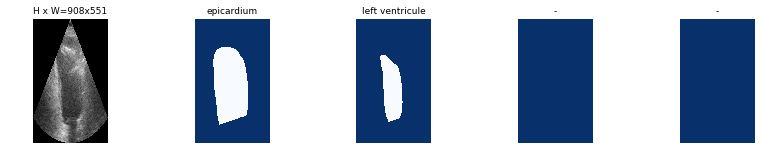

133


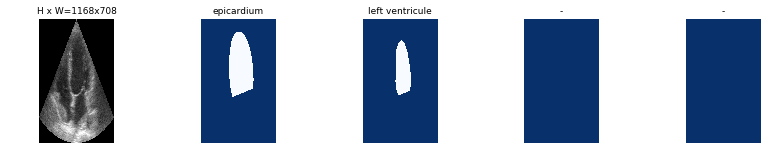

127


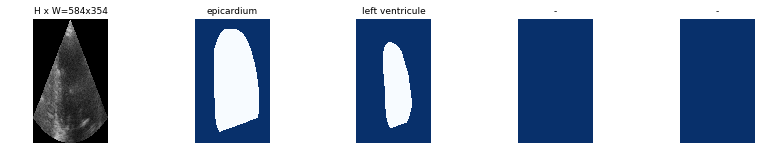

177


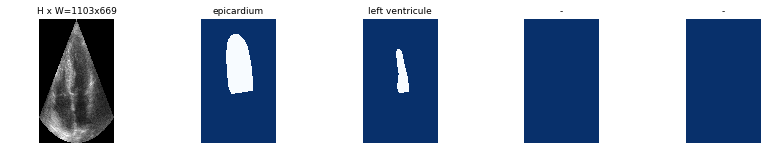

In [7]:
image_ids = np.random.choice(dataset.image_ids, 4)
# Once again, image_id is a number and not the path
print(dataset.image_ids)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Choose weights

In [ ]:
# Which weights to start with ?
# imagenet, coco, last or custom
init_with = "custom"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
    model_path = "/floyd/home/logs/CAMUS/mask_rcnn_camus_0050.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name = True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Pass `layers="all"` to train all layers.

In [ ]:
model.train(dataset_train, dataset_val,
                    learning_rate = config.LEARNING_RATE,
                    epochs = 20,
                    layers = 'heads')

In [ ]:
'''
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
'''
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='4+')

In [ ]:
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=60,
            layers='all')

<a id='detect'></a>

# III. Detect
Load the model for inference and choose the weights, then display the results and the groundtruth.

In [42]:
def detect (model, image_path=None): 
    # Run model detection 
    print("Running on {}".format(args.image))
    # Read image
    image = sitk.GetArrayFromImage(sitk.ReadImage(mask_id, sitk.sitkFloat32))
    # Detect objects
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [43]:
infConf = CamusInferenceConfig()
infConf.display()
model = modellib.MaskRCNN(mode = "inference", 
                          config = infConf,
                          model_dir = MODEL_DIR)

init_with = "custom"  # imagenet, coco, or last or custom

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
    model_path = "/floyd/home/logs/CAMUS/mask_rcnn_camus_0050.h5"
    model_path = "/floyd/home/logs/CAMUS/mask_rcnn_camus_0043.h5"

        
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        2
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

## Segmentation Masks : Groundtruth *VS* Detection
The 2 following cells are for the resized masks.

19
original_image           shape: (448, 448, 3)         min:    0.00000  max:  254.99501  float32
image_meta               shape: (15,)                 min:    0.00000  max: 1102.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:   68.00000  max:  295.00000  int32
gt_mask                  shape: (448, 448, 2)         min:    0.00000  max:    1.00000  float32


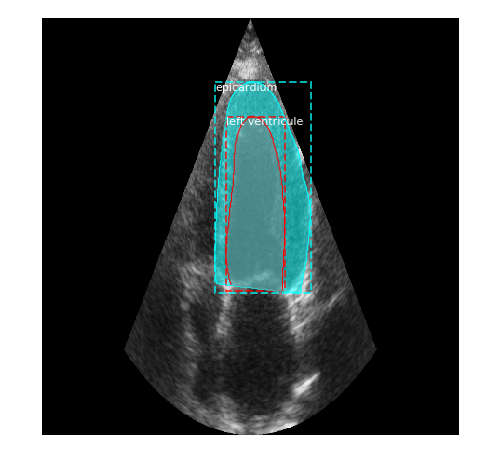

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  254.99501  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  151.09501  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32
[1 2] vs [1 2]


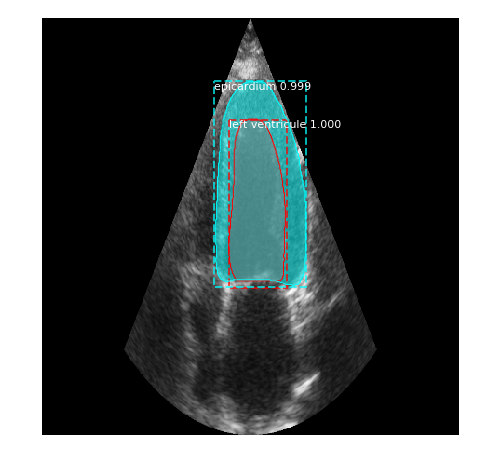

In [44]:
dataset = dataset_test
image_id = np.random.choice(dataset.image_ids)
print(image_id)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, infConf, 
                           image_id, use_mini_mask=False)
from mrcnn.model import log
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Display the gt mask
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                        dataset.class_names, figsize=(8, 8))

# Segmentation
results = model.detect([original_image], verbose=1)
r = results[0]
# Display the detected mask and confidence
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                        dataset.class_names, r['scores'], ax=get_ax())
print(r['class_ids'],"vs",gt_class_id)

The 2 following cells are for the masks with original size.

original_image           shape: (1038, 630, 3)        min:    0.00000  max:  255.00000  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_mask                  shape: (1038, 630, 2)        min:    0.00000  max:    1.00000  float32
gt_bbox                  shape: (2, 4)                min:   90.00000  max:  677.00000  int32


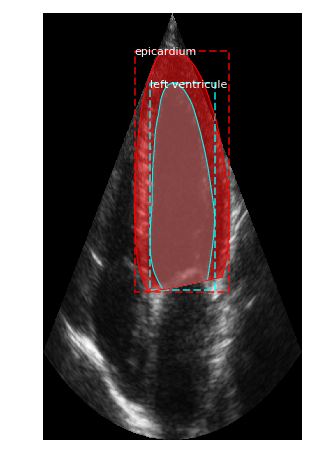

Processing 1 images
image                    shape: (1038, 630, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  150.66422  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1038.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32
original_image           shape: (1038, 630, 3)        min:    0.00000  max:  255.00000  float32
detect_class_id          shape: (2,)                  min:    1.00000  max:    2.00000  int32
detect_bbox              shape: (2, 4)                min:  100.00000  max:  672.00000  int32
detect_mask              shape: (1038, 630, 2)        min:    0.00000  max:    1.00000  bool


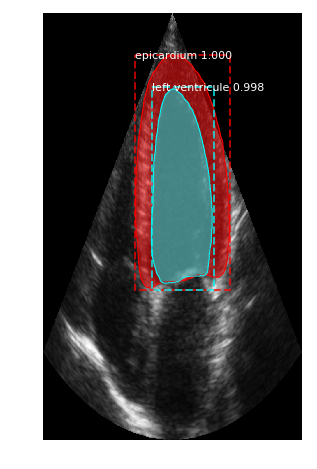

In [45]:
import tensorflow as tf
with tf.device("/gpu:0"):
    # Choose a random image from the dataset.
    image_id = np.random.choice(dataset.image_ids)
    image_id = 20
    original_image = dataset.load_image(image_id)
    gt_mask,gt_class_id = dataset.load_mask(image_id)
    gt_bbox = utils.extract_bboxes(gt_mask)
    
    from mrcnn.model import log
    log("original_image", original_image)
    log("gt_class_id", gt_class_id)
    log("gt_mask", gt_mask)
    log("gt_bbox", gt_bbox)
    
    # Display the groundtruth mask
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))
    
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    # Display the detected mask and confidence
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax())
    log("original_image", original_image)
    log("detect_class_id", r['class_ids'])
    log("detect_bbox", r['rois'])
    log("detect_mask", r['masks'])

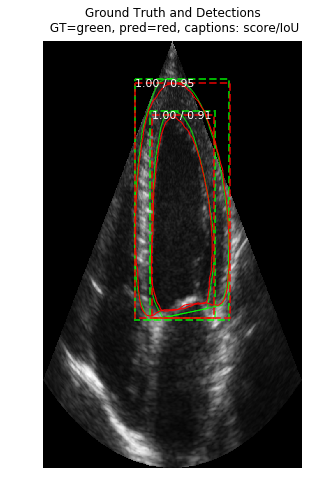

In [46]:
# Display the differences
visualize.display_differences(original_image,gt_bbox,gt_class_id,gt_mask, r['rois'], r['class_ids'],r['scores'], r['masks'],
                            dataset.class_names, ax=get_ax(), show_mask = False, show_box = True)

# Bounding boxes errors in millimeters and IoU

In [53]:
def normalize_bbox(gt_bbox, seg):    
    """
     Get the center coordinates of gt BBox and segmentation BBox as well
     as width and height of BBox. Masks are generated in radom class order,
     for example : 2,3,1
     gt_bbox: numpy array with coordinates (y1, x1, y2, x2)
              top left corner and bottom right corner coordinates.
        
     seg: dictionary result of model.detect[0]
     returns : numpy arrays for gt and segmentation
     each array is 2 dimentional, one line per class:  (xcenter, ycenter, width, height) 
    """

    # Init with nan to skip these values when computing mean and std
    # with np.nanmean and np.nanstd
    seg_bbox_reshape = np.empty(gt_bbox.shape)
    gt_bbox_reshape = np.empty(gt_bbox.shape)
    seg_bbox_reshape[:,:] = np.nan
    gt_bbox_reshape[:,:] = np.nan
    
    # Check if there's at least one mask
    if (seg['class_ids'].ndim > 0):
        # Check if all masks are detected
        if (len(seg['class_ids']) == 2):
            # Go through the segmentation masks of each class
            j = 0
            # Go through the gt masks according to the class order of segmentation masks
            for i in seg['class_ids']:

                # (y1 + y2) / 2
                gt_bbox_reshape[j,1] = (gt_bbox [j,0] + gt_bbox [j,2]) / 2
                seg_bbox_reshape[i-1,1] = (seg['rois'][j,0] + seg['rois'][j,2]) / 2
                # (x1 + x2) / 2
                gt_bbox_reshape[j,0] = (gt_bbox [j,1] + gt_bbox [j,3]) / 2
                seg_bbox_reshape[i-1,0] = (seg['rois'][j,1] + seg['rois'][j,3]) / 2
                # (y2 - y1)
                gt_bbox_reshape[j,3] = gt_bbox [j,2] - gt_bbox [j,0]
                seg_bbox_reshape[i-1,3] = seg['rois'][j,2] - seg['rois'][j,0] 
                # (x2 - x1)
                gt_bbox_reshape[j,2] = gt_bbox [j,3] - gt_bbox [j,1]
                seg_bbox_reshape[i-1,2] = seg['rois'][j,3] - seg['rois'][j,1]
                j += 1
        # If missing masks, reshape all the gt but only the detected masks
        # nan values will remain for none detected masks
        else:
            for i in np.arange(1,infConf.NUM_CLASSES):
                gt_bbox_reshape[i-1,1] = (gt_bbox [i-1,0] + gt_bbox [i-1,2]) / 2
                gt_bbox_reshape[i-1,0] = (gt_bbox [i-1,1] + gt_bbox [i-1,3]) / 2
                gt_bbox_reshape[i-1,3] = gt_bbox [i-1,2] - gt_bbox [i-1,0]
                gt_bbox_reshape[i-1,2] = gt_bbox [i-1,3] - gt_bbox [i-1,1]
            j = 0
            for i in seg['class_ids']:
                seg_bbox_reshape[i-1,1] = (seg['rois'][j,0] + seg['rois'][j,2]) / 2
                seg_bbox_reshape[i-1,0] = (seg['rois'][j,1] + seg['rois'][j,3]) / 2
                seg_bbox_reshape[i-1,3] = seg['rois'][j,2] - seg['rois'][j,0] 
                seg_bbox_reshape[i-1,2] = seg['rois'][j,3] - seg['rois'][j,1]
                j += 1 
    else:
        print("No mask")
        pass

    return gt_bbox_reshape, seg_bbox_reshape

                                         
def compute_bbox_errors(gt_bbox, seg_bbox, class_ids, im_id):   
    """
    Compute errors between gt BBoxes and segmentation BBoxes 
    gt_bbox, seg_bbox : numpy arrays as returned by normalize_bbox
    returns a 2D numpy array containing the error for each class
    height and width erros are in millimeters
    """

    # Init with nan to skip these values when computing mean and std
    error = np.empty(gt_bbox.shape)
    error[:,:] = np.nan
    
    # Check if there is at least a mask
    if (seg_bbox.ndim > 0):
        error = abs (gt_bbox - seg_bbox)
        for i in np.arange(0,error.shape[0]):
            
            # Return coordinates in millimiters
            error[i,2] *= voxel_spacing[0]
            error[i,0] *= voxel_spacing[0]
            error[i,1] *= voxel_spacing[1]
            error[i,3] *= voxel_spacing[1]
            
            # One number precision only
            error[i,0] = "%.1f" % error[i,0]
            error[i,1] = "%.1f" % error[i,1]
            error[i,2] = "%.1f" % error[i,2]
            error[i,3] = "%.1f" % error[i,3]
            
    else: 
        pass
    return error 

In [54]:
errors = []
image_ids = dataset.image_ids
# image_ids = [35]
for image_id in image_ids:
    original_image = dataset.load_image(image_id)
    gt_mask,gt_class_id = dataset.load_mask(image_id)
    gt_bbox = utils.extract_bboxes(gt_mask)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    gt_reshaped, seg_reshaped = normalize_bbox (gt_bbox, r)
    error = compute_bbox_errors (gt_reshaped, seg_reshaped, r['class_ids'], image_id)
    # Get the errors of epicarium only to compare to LUNET paper
    errors.append(error[1,:])
    
print(np.nanmean(errors, axis=0))
print(np.nanstd(errors,axis=0))

[1.325  1.2355 2.73   2.892 ]
[1.27176059 1.10425982 2.41333794 2.7672976 ]


  
|Error (mm)                                                                      |
| ----------------------------------------------------------------------------- |

|                 | xc              | yc            | h             | w         |    
| --------------- | --------------- | ------------- | ------------- | --------- |
|mean             |1.2              |1.4            |2.9            |2.8        |
|std              |1.1              |1.1            |2.6            |2.0        |

<a id='save'></a>
# IV. Saving output masks original format
This cell is used to save the detection masks in the original CAMUS format (not binaray masks).

In [ ]:
save_path = '/floyd/home/res/'
if (not os.path.exists(save_path)):
    os.mkdir(save_path)

image_ids = dataset.image_ids
# Voxel spacing
spacing = [0.308,0.154,1.54]
# Fully print matrices/tensors
np.set_printoptions(threshold=sys.maxsize)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Convert to int
    r['masks'] = r['masks'].astype(int)
    
    # Check if any class is missing
    check_missing = True
    # Get the detections masks and fill new image with corresponding class values
    # one for lv, two for epi and three for la, masks generated are not oredered
    if (r['masks'].ndim > 2):
        if (r['masks'].shape[2] > 0):
            result = np.where(r['masks'][:,:,0] == 1,r['class_ids'][0],0)
            check_missing = True
        if (r['masks'].shape[2] > 1):
            result = np.where(r['masks'][:,:,1] == 1,r['class_ids'][1],result)
            check_missing = True
        if (r['masks'].shape[2] > 2):
            result = np.where(r['masks'][:,:,2] == 1,r['class_ids'][2],result)
            check_missing = False
        if (check_missing):
            print ("Detected only classes :", r['class_ids']," for id",image_id,": ",dataset.image_info[image_id]['id'])
    else:
        print ("No masks detected for {}".format(dataset.image_info[image_id]['id']))
    result = result.astype('uint8')
    
    # -7 to get the patient's number as a folder
    full_path = os.path.join(save_path,dataset.image_info[image_id]['id'][:-7]) 
    if (not os.path.exists(full_path)):
        os.mkdir(full_path)
        
    filename = os.path.join(full_path, dataset.image_info[image_id]['id'] + '.mhd')
    image = sitk.GetImageFromArray(result, isVector=False)
    image.SetSpacing(spacing)
    sitk.WriteImage(image,filename,False)

<a id='evaluate'></a>

# V. EVALUATE
Evaluate the Dice, HD and ASSD on test dataset with 200 images.

1) Mask RCNN 

Best scores so far :

| Class           | Dice          | HD (mm)       | ASSD (mm) |    
| --------------- | ------------- | ------------- | --------- |
|Left ventricule  |0.92           |5.20           |1.66       |
|Epicardium       |0.95           |5.97           |1.94       |
|Left atrium      |0.90           |5.45           |1.95       |
|Average          |0.92           |5.54           |1.85       |

* Number of False negatives : 3 *Left ventricules*.
* Number of False positives : 0.

2) [Unet](http://camus.creatis.insa-lyon.fr/challenge/#phase/5ca211272691fe0a9dac46d6)

| Class           | Dice          | HD (mm)       | ASSD (mm) |    
| --------------- | ------------- | ------------- | --------- |
|Left ventricule  |0.93           |5.37           |1.69       |
|Epicardium       |0.96           |5.49           |1.82       |
|Left atrium      |0.91           |5.54           |2.10       |
|Average          |0.93           |5.47           |1.87       |

* Number of False negatives : Unknown.
* Number of False positives : Unknown.

In [47]:
def dice (gt, segmentation, _id):
    """
    Compute the dice metric. 
    gt: Groundtruth binary masks for each class. 
    seggmentation: Dictionary result of segmentation returned by model.detect[0]. 
    returns a dictionary containing the dice value for each class
    the keys of the dictionary are the classes and the values, the dice 
    values per class.
    """
    
    # Each key of the dictionary corresponds to one of the 3 classses
    metrics = dict([
        (1,0),
        (2,0),
        (3,0),
    ])
    
    # Check if there have missing masks 
    check_missing = True
    # Make sure there are masks
    if (segmentation['masks'].ndim > 2):
        # Minimum one mask detected ?
        if (segmentation['masks'].shape[2] > 0):
            metrics[segmentation['class_ids'][0]] = metric.binary.dc(gt[:,:,segmentation['class_ids'][0]-1],                                   segmentation['masks'][:,:,0])
            check_missing = True
        # Minimum 2 masks detected ?
        if (segmentation['masks'].shape[2] > 1):
            metrics[segmentation['class_ids'][1]] = metric.binary.dc(gt[:,:,segmentation['class_ids'][1]-1],                                   segmentation['masks'][:,:,1])
            check_missing = False
        if (check_missing):
            # Show which classes were detected for the missing masks image
            print ("Only following classes detected for id ",_id,":",segmentation['class_ids'])
        return metrics
    else:
        print ("No masks detected for id: ",_id)
        pass
        
        
def assd (gt, segmentation, _id):
    """
    Compute the assymetric surface distance metric in millimeters (mm).
    gt: Groundtruth binary masks for each class.
    segmentation: Dictionary result of segmentation returned by model.detect[0]. 
    returns a dictionary containing the assd value for each class
    the keys of the dictionary are the classes and the values, the assd 
    values per class.
    """
    
    metrics = dict([
        (1,0),
        (2,0),
        (3,0),
    ])
    
    if (segmentation['masks'].ndim > 2):
        if (segmentation['masks'].shape[2] > 0):
            metrics[segmentation['class_ids'][0]] = metric.binary.assd(gt[:,:,segmentation['class_ids'][0]-1],                                 segmentation['masks'][:,:,0], voxelspacing = [voxel_spacing[1], voxel_spacing[0]])
        if (segmentation['masks'].shape[2] > 1):
            metrics[segmentation['class_ids'][1]] = metric.binary.assd(gt[:,:,segmentation['class_ids'][1]-1],                                 segmentation['masks'][:,:,1], voxelspacing = [voxel_spacing[1], voxel_spacing[0]])
        return metrics
    else:
        print ("No masks detected for id: ",_id)
        pass
    

def hd (gt, segmentation, _id):
    """
    Compute the hausdorff distance metric in mm.
    gt: Groundtruth binary masks for each class. 
    segmentation: Dictionary result of segmentation returned by model.detect[0]. 
    returns a dictionary containing the hd value for each class
    the keys of the dictionary are the classes and the values, the hd 
    values per class.
    """
    
    metrics = dict([
        (1,0),
        (2,0),
        (3,0),
    ])
    
    if (segmentation['masks'].ndim > 2):
        if (segmentation['masks'].shape[2] > 0):
            metrics[segmentation['class_ids'][0]] = metric.binary.hd(gt[:,:,segmentation['class_ids'][0]-1],segmentation['masks'][:,:,0], voxelspacing = [voxel_spacing[1], voxel_spacing[0]])
        if (segmentation['masks'].shape[2] > 1):
            metrics[segmentation['class_ids'][1]] = metric.binary.hd(gt[:,:,segmentation['class_ids'][1]-1],segmentation['masks'][:,:,1], voxelspacing = [voxel_spacing[1], voxel_spacing[0]])   
        return metrics
    else:
        print ("No masks detected for id: ",_id)
        pass

In [48]:
image_ids = dataset.image_ids
# Use a dictionary with class_ids as the keys
# Use a list for dice, first element is dice value and
# second element is a counter of detected classes to use for mean calculation
dice_dict = dict([
        (1,[0,0]),
        (2,[0,0]),
        (3,[0,0]),
    ])
# The counter depends on detected classes, so the dice counter will
# be used for HD and ASSD
hd_dict = dict([
        (1,0),
        (2,0),
        (3,0),
    ])
assd_dict = dict([
        (1,0),
        (2,0),
        (3,0),
    ])
for image_id in image_ids:
   # Load image and ground truth data
    image = dataset.load_image(image_id)
    gt_mask,gt_class_id = dataset.load_mask(image_id)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    dices = dice (gt_mask, r, image_id) 
    assds = assd (gt_mask, r, image_id) 
    hds = hd (gt_mask, r, image_id) 
    
    # Check which masks are detected and take only them in account
    if (r['class_ids'].shape[0] > 0):
        # Minimum one mask
        # Assign the dice value to the corresponding class
        dice_dict[r['class_ids'][0]][0] += dices[r['class_ids'][0]]
        assd_dict[r['class_ids'][0]] += assds[r['class_ids'][0]]
        hd_dict[r['class_ids'][0]] += hds[r['class_ids'][0]]
        # Increment the counter for this class
        dice_dict[r['class_ids'][0]][1] += 1
    if (r['class_ids'].shape[0] > 1):
        # Minimum two masks
        dice_dict[r['class_ids'][1]][0] += dices[r['class_ids'][1]]
        assd_dict[r['class_ids'][1]] += assds[r['class_ids'][1]]
        hd_dict[r['class_ids'][1]] += hds[r['class_ids'][1]]
        dice_dict[r['class_ids'][1]][1] += 1
    if (r['class_ids'].shape[0] > 2):
        # Minimum 3 masks
        dice_dict[r['class_ids'][2]][0] += dices[r['class_ids'][2]]
        assd_dict[r['class_ids'][2]] += assds[r['class_ids'][2]]
        hd_dict[r['class_ids'][2]] += hds[r['class_ids'][2]]
        dice_dict[r['class_ids'][2]][1] += 1
        
# Make sure at least one mask per class is detected 
try:
    # Divide the sum by the counter for each class
    print ("Dice :",dice_dict[1][0] / dice_dict[1][1],", ",dice_dict[2][0] / dice_dict[2][1])
    print ("ASSD :",assd_dict[1] / dice_dict[1][1],", ",assd_dict[2] / dice_dict[2][1])
    print ("HD :",hd_dict[1] / dice_dict[1][1],", ",hd_dict[2] / dice_dict[2][1])
except ZeroDivisionError:
    print ("DIVISION BY ZERO ! No mask were detected for a class")

Only following classes detected for id  12 : [2]
Only following classes detected for id  46 : [2]
Only following classes detected for id  93 : [2]
Dice : 0.9244952052321987 ,  0.9441926497397009
ASSD : 1.6780665894493136 ,  2.0197913246344315
HD : 5.324980403903682 ,  6.048362369930983


In [25]:
# Make sure at least one mask per class is detected 
try:
    # Divide the sum by the counter for each class
    print ("Dice :",dice_dict[1][0] / dice_dict[1][1],", ",dice_dict[2][0] / dice_dict[2][1])
    print ("ASSD :",assd_dict[1] / dice_dict[1][1],", ",assd_dict[2] / dice_dict[2][1])
    print ("HD :",hd_dict[1] / dice_dict[1][1],", ",hd_dict[2] / dice_dict[2][1])
except ZeroDivisionError:
    print ("DIVISION BY ZERO ! No mask were detected for a class")

Dice : 0.9246238374656947 ,  0.9442364074892652
ASSD : 1.673102035388745 ,  2.0140448897867818
HD : 5.310235840753559 ,  6.027897725937514


<a id='inspect'></a>

# VI. Inspect detection
Go through the detection process step by step.

In [52]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
image = dataset.load_image(image_id)
gt_mask,gt_class_id = dataset.load_mask(image_id)
# Run object detection
results = model.detect([image], verbose=0)
r = results[0]

target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (50127,)              min:    0.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:  -25.41165  max:  266.49087  float64
positive_anchors         shape: (128, 4)              min:  -26.50967  max:  485.25483  float64
negative_anchors         shape: (0, 4)                min:             max:             float64
neutral anchors          shape: (49999, 4)            min: -362.03867  max:  746.03867  float64
refined_anchors          shape: (128, 4)              min:  239.99997  max:  884.00061  float32


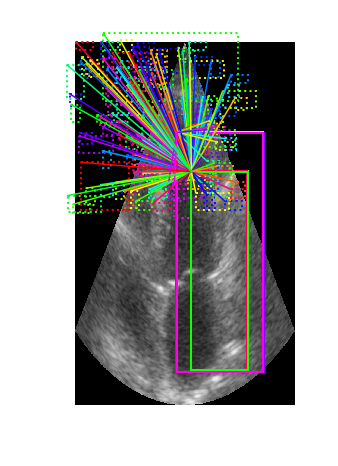

In [53]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [54]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 50127, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.80993  max:    1.66675  float32
refined_anchors          shape: (1, 6000, 4)          min:  -17.01881  max:   18.18729  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (207,)                min:    0.00000  max: 5843.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


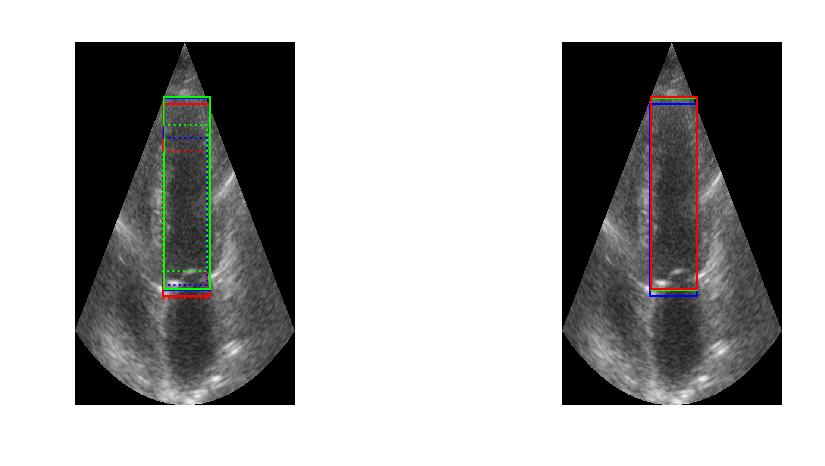

In [55]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 3
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

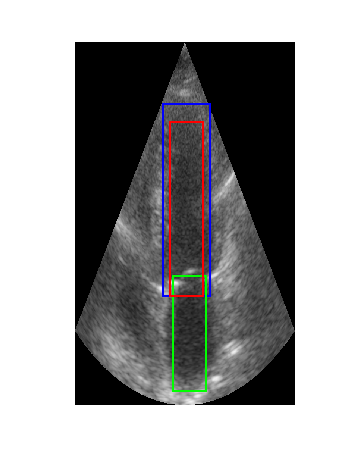

In [56]:
# Show refined anchors after non-max suppression
limit = 3
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [20]:
voxel_spacing = [0.308,0.154]

def assd_all (gt_mask,r):
    res=0.0
    
    #metrics=np.zeros(3)
    for i in range(0,r['masks'].shape[2]):
        #Masks are ordered (according to class_ids) in ground truth and disordred in detection
        #Compare the corresponding masks
       #metrics[r['class_ids'][i]-1]+=metric.binary.assd(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i],voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
        if (r['masks'].any()):
            res+=metric.binary.assd(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i],voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
    if(r['masks'].shape[2]<3):
        print("missing",r['class_ids'])
    #res=metrics.sum()
    return res/(float)(r['masks'].shape[2])
def hd_all (gt_mask,r):
    res=0.0
    for i in range(0,r['masks'].shape[2]):
        if (r['masks'].any()):
            res+=metric.binary.hd(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i],voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
    return res/(float)(r['masks'].shape[2])
def dice_all(gt_mask,r):
    res=0.0
    for i in range (0,r['masks'].shape[2]):
        if (r['masks'].any()):
            res+=metric.binary.dc(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i])
    return res/(float)(r['masks'].shape[2])

In [46]:

image_ids = np.random.choice(dataset.image_ids, 1)
print(image_ids)
image_ids = dataset.image_ids
#image_ids = [60]
APs = []
DICEs = []
HDs = []
ASSDs = []
for image_id in image_ids:
   # Load image and ground truth data
        image=dataset.load_image(image_id)
        gt_mask,gt_class_id=dataset.load_mask(image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        #AP, precisions, recalls, overlaps =\
            #utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
             #                r["rois"], r["class_ids"], r["scores"], r['masks'])
        #APs.append(AP)
    # Compute dice 
        #print(image_id)
        DICEs.append(dice_all(gt_mask,r))
        ASSDs.append(assd_all(gt_mask,r))
        HDs.append(hd_all(gt_mask,r))
print('mean dice :',np.mean(DICEs))
print('mean assd :',np.mean(ASSDs))
print('mean hd :',np.mean(HDs))

[31]
missing [3 2]
missing [2 3]
missing [2 3]
mean dice : 0.9230053716786136
mean assd : 1.8524441532320555
mean hd : 5.53807670496695


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb3c2ee5780>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb3c2ee5e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb3c2ee5630>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb3c2ef04e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb3c2ef0828>],
 'means': []}

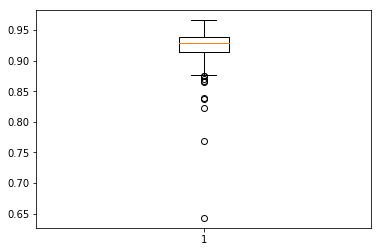

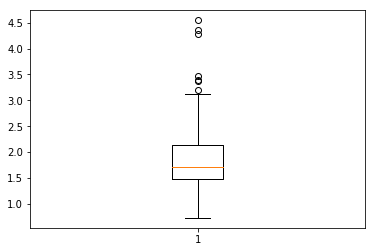

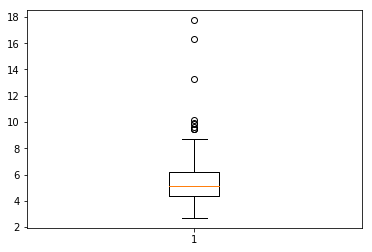

In [47]:
fig1, ax1 = plt.subplots()
ax1.boxplot(DICEs)
fig2, ax2 = plt.subplots()
ax2.boxplot(ASSDs)
fig3, ax3 = plt.subplots()
ax3.boxplot(HDs)

<a id='png'></a>

# VII. Save segmentation's differences in `png` format


Processing 1 images
image                    shape: (973, 590, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  973.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32


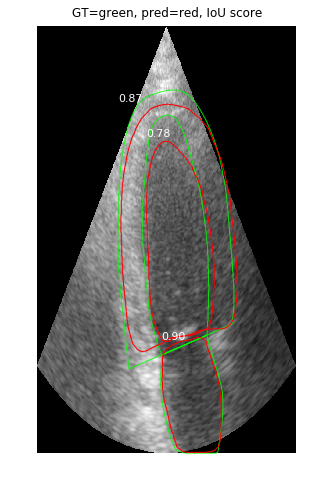

In [31]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from matplotlib import patches,  lines

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def save_instances(path, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig(path)

def save_differences(path, image,
                        gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5):
    """Display ground truth and prediction instances on the same image."""
    # Match predictions to ground truth
    gt_match, pred_match, overlaps = utils.compute_matches(
        gt_box, gt_class_id, gt_mask,
        pred_box, pred_class_id, pred_score, pred_mask,
        iou_threshold=iou_threshold, score_threshold=score_threshold)
    # Ground truth = green. Predictions = red
    colors = [(0, 1, 0, .8)] * len(gt_match)\
           + [(1, 0, 0, 1)] * len(pred_match)
    # Concatenate GT and predictions
    class_ids = np.concatenate([gt_class_id, pred_class_id])
    scores = np.concatenate([np.zeros([len(gt_match)]), pred_score])
    boxes = np.concatenate([gt_box, pred_box])
    masks = np.concatenate([gt_mask, pred_mask], axis=-1)
    # Captions per instance show score/IoU
    captions = ["" for m in gt_match] + ["{:.2f}".format(
        (overlaps[i, int(pred_match[i])]
            if pred_match[i] > -1 else overlaps[i].max()))
            for i in range(len(pred_match))]
    # Set title if not provided
    title = title or "GT=green, pred=red, IoU score"
    # Save
    save_instances(
        path, image,
        boxes, masks, class_ids,
        class_names, scores, ax=ax,
        show_bbox=show_box, show_mask=show_mask,
        colors=colors, captions=captions,
        title=title)

In [ ]:
image_ids = dataset.image_ids
# Path to save the images in 
save_path = "/floyd/home/res_png"
if (not os.path.exists(save_path)):
    os.mkdir(save_path)
for image_id in image_ids:
    original_image = dataset.load_image(image_id)
    gt_mask,gt_class_id = dataset.load_mask(image_id)
    gt_bbox = utils.extract_bboxes(gt_mask)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    path = os.path.join(save_path,dataset.image_info[image_id]['id'] + ".png")
    save_differences(path, original_image,gt_bbox,gt_class_id,gt_mask, r['rois'], r['class_ids'],r['scores'], r['masks'],
                            dataset.class_names, ax=get_ax(), show_mask=False, show_box=False)